In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1
torchvision version: 0.20.1


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary


In [3]:
from helpers import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [8]:
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, batch_size=BATCH_SIZE, transform=manual_transforms)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x30a453740>,
 ['pizza', 'steak', 'sushi'])

In [9]:
image_batch, label_patch = next(iter(train_dataloader))

image, label = image_batch[0], label_patch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

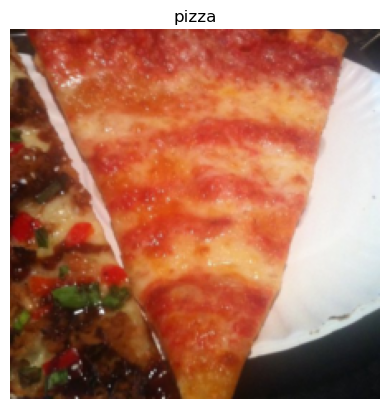

In [10]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [11]:
height = 224
width = 224
color_channels = 3
patch_size = 16
number_of_patches = int((height * width) / patch_size ** 2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [12]:
# Input layer shape
embedding_layer_input_shape = (height, width, color_channels)

# Output layer shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)

print(f"Input shape (2D image): {embedding_layer_input_shape}")
print(f"Output shape (2D image): {embedding_layer_output_shape}")

Input shape (2D image): (224, 224, 3)
Output shape (2D image): (196, 768)


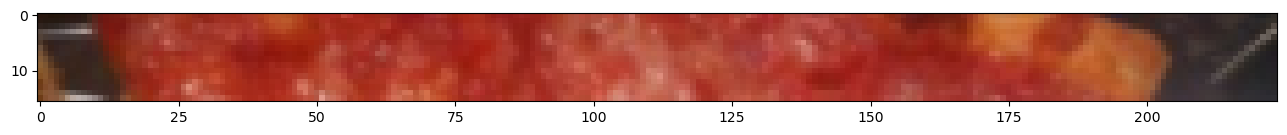

In [13]:
# Permute image to be compatible with matplotlib
image_permuted = image.permute(1, 2, 0)
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


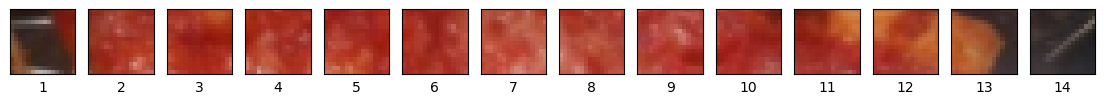

In [14]:
# Splitting data into batches by patch_size
img_size = 224
num_patches = img_size / patch_size
assert img_size % num_patches == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1, ncols=img_size // patch_size, figsize=(num_patches, num_patches), sharex=True, sharey=True)

# Displaying the patches of a single row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


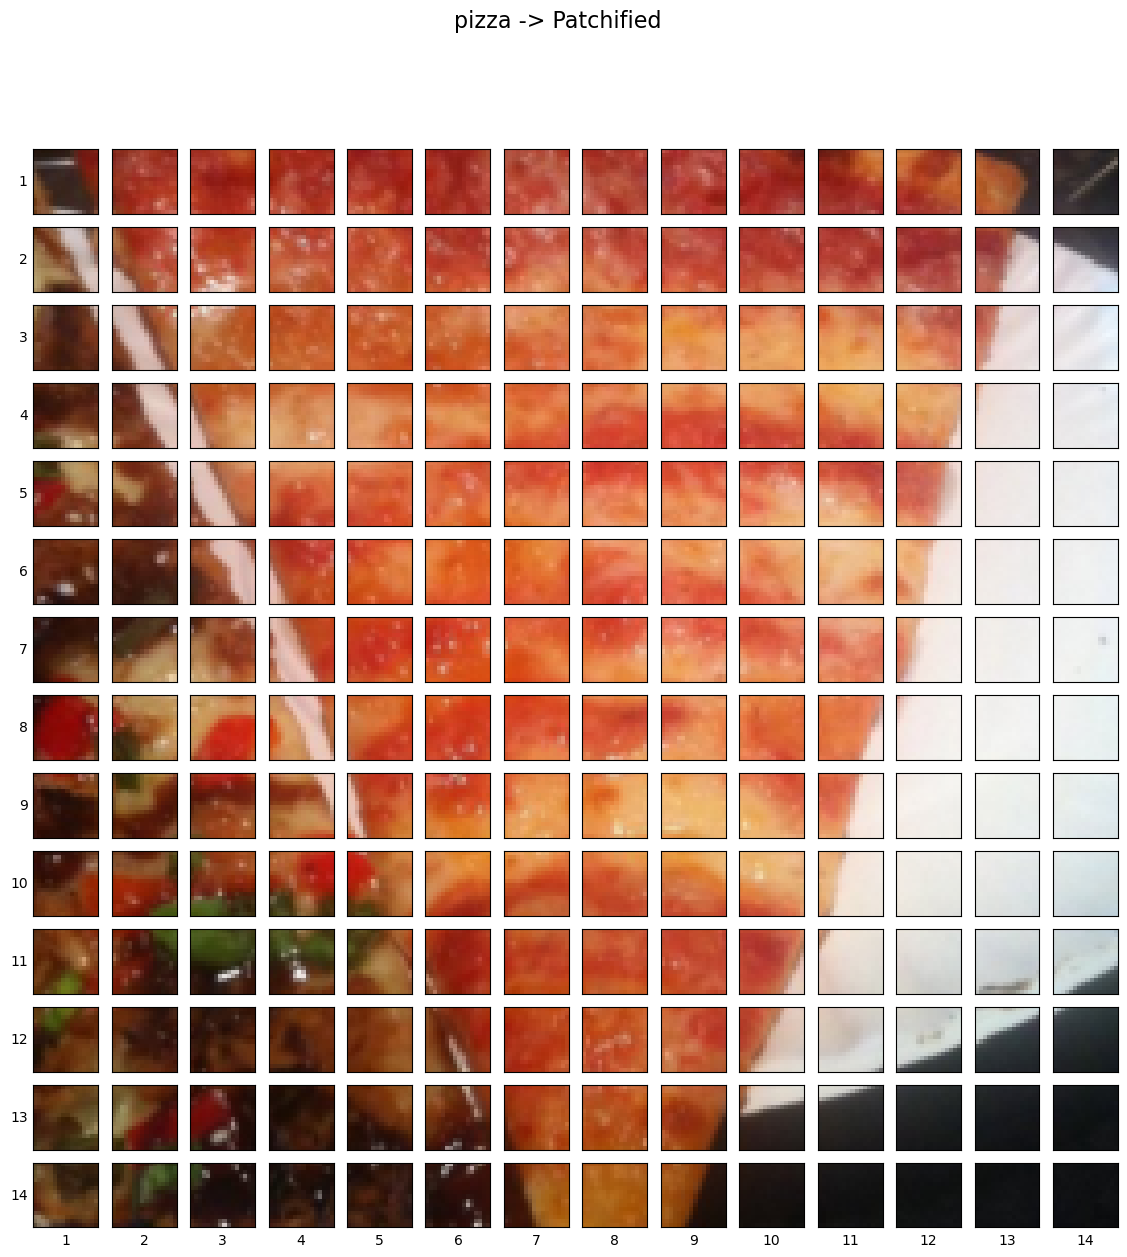

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

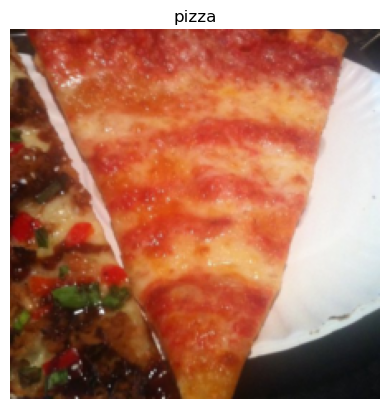

(batch, height, width, color_channels): torch.Size([1, 768, 14, 14])


In [16]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride = patch_size, padding=0)

# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
plt.show()

# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(f"(batch, height, width, color_channels): {image_out_of_conv.shape}")

Showing random convolutional feature maps from indexes: [349, 312, 181, 334, 92]


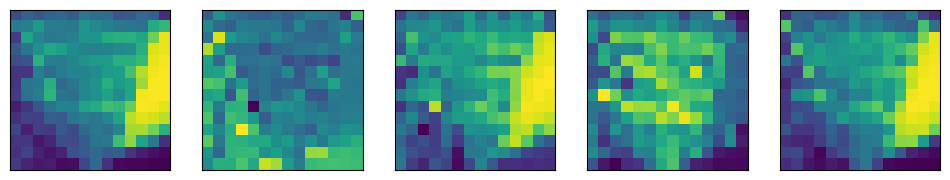

In [17]:
import random

random_indexes = random.sample(range(0, 768), k = 5)
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize= (12, 12))
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

for i, idx in enumerate(random_indexes):
  image_conv_feat_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feat_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


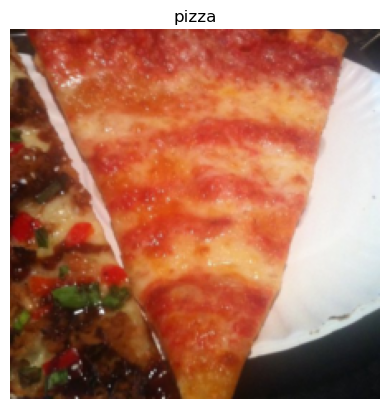

In [18]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, end_dim=3)

# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [19]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


In [22]:
# Now to combine everything to achieve all of the embedding layer steps

class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """

  def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                                  out_channels=embedding_dim,
                                  kernel_size=patch_size,
                                  stride=patch_size,
                                  padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    return x_flattened.permute(0, 2, 1)


In [23]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


**Learning Embeddings**: Preprend a learnable embedding to the sequence of embedded patches

To do so we can define the following pseudocode:

```
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

In [24]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create a class token embedding as a learnable parameter

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), requires_grad=True)

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [25]:
# Add the class token embedding to the front of the patch embedding

patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
         [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
         ...,
         [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
         [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
         [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [26]:
number_of_patches = int((height * width) / patch_size ** 2)
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)

print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches + 1, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches + 1, embedding_dimension]


In [27]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6824, 0.9959, 0.8280,  ..., 1.1169, 0.8776, 1.1116],
         [0.4580, 1.0366, 0.9952,  ..., 1.2777, 0.7499, 1.1885],
         ...,
         [0.9177, 1.0138, 0.9472,  ..., 1.0683, 0.9584, 1.0268],
         [0.9225, 1.0112, 0.9483,  ..., 1.0678, 0.9748, 1.0285],
         [0.9198, 1.0089, 0.9567,  ..., 1.0599, 0.9651, 1.0213]]],
       grad_fn=<AddBackward0>)

In [28]:
set_seeds()

# Flow of Equation 1 from Paper

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [29]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attn_dropout: float = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [30]:
multihead_attention_block = MultiheadSelfAttention(embedding_dim=768, num_heads=12)
patched_image_through_msa_block = multihead_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [31]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: float = 0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size), 
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim), 
            nn.GELU(), 
            nn.Dropout(p=dropout), 
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x 

In [32]:
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [33]:
# Create Transformer Encoder 

class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttention(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x         

In [34]:
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttention (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [35]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

       
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [36]:
# Quick demo:

batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) 
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [37]:
set_seeds()
rand_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=len(class_names))
vit(rand_image_tensor)

tensor([[0.2686, 1.0315, 1.3099]], grad_fn=<AddmmBackward0>)

In [39]:
# Training 

from helpers import engine
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, 
                             betas = (0.9, 0.999), 
                             weight_decay=0.3)

loss = torch.nn.CrossEntropyLoss()
set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss,
                       epochs=5,
                       device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8351 | train_acc: 0.2578 | test_loss: 1.3259 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1646 | train_acc: 0.2695 | test_loss: 1.0194 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1619 | train_acc: 0.3242 | test_loss: 1.3355 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1711 | train_acc: 0.3125 | test_loss: 1.2907 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.1905 | train_acc: 0.2930 | test_loss: 2.0880 | test_acc: 0.1979


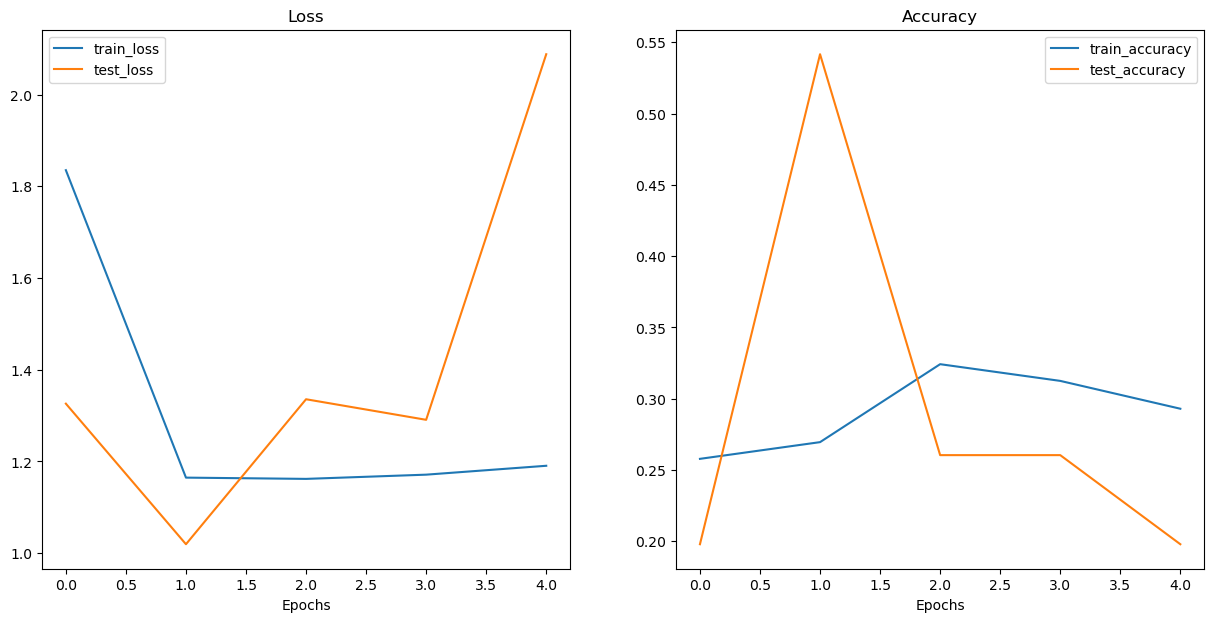

In [40]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)